In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cvxpy as cp
import polytope as pc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from cvxpylayers.torch import CvxpyLayer
from tqdm import tqdm
import matplotlib.pyplot as plt

from evanqp import QPProblem, MPCProblem, Polytope, RandomSampler, FFNN, Verifier
from evanqp.layers import Bound, BaseLayer, SeqLayer, LinearLayer, ReluLayer, QPLayer
from utils import dlqr

In [3]:
torch.manual_seed(4)
np.random.seed(4)

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

In [4]:
class DCDCConverter(MPCProblem):
    def __init__(self, N=10):
        self.N = N

        n = 2
        m = 1

        # Linearized dynamics
        self.A = np.array([[0.971356387900839, -0.009766890567613], [1.731870774203751, 0.970462385352837]])
        self.B = np.array([[0.148778899882612], [0.180827260808426]])
        self.C = np.array([[0, 1]])
        
        # Steady state
        ref = 5.0
        ss = np.linalg.solve(np.block([[self.A - np.eye(n), self.B],[self.C, 0]]), np.array([0, 0, ref]))
        self.xs = ss[0:2]
        self.us = ss[2:3]

        # Weights
        self.Q = np.diag([90, 1])
        self.R = np.array([[1]])
        self.K, self.P, _ = dlqr(self.A, self.B, self.Q, self.R)
        
        # Constraints
        self.x_max = np.array([0.2, 7.0])
        self.x_min = np.array([0.0, 0.0])
        self.u_max = np.array([1.0])
        self.u_min = np.array([0.0])
        
        # Terminal Set computation (shifted)
        # state constraints
        Hx = np.vstack((np.eye(n), -np.eye(n)))
        hx = np.concatenate((self.x_max-self.xs, -(self.x_min-self.xs)))
        # input constraints
        Hu = np.vstack((np.eye(m), -np.eye(m)))
        hu = np.concatenate((self.u_max-self.us, -(self.u_min-self.us)))
        # closed loop dynamics
        Ak = self.A - self.B @ self.K
        # state & input constraints
        HH = np.vstack((Hx, -Hu @ self.K))
        hh = np.concatenate((hx, hu))
        # compute maximal invariant set
        O = pc.Polytope(HH, hh)
        while True:
            O_prev = O
            # pre-set
            O = O.intersect(pc.Polytope(O.A @ Ak, O.b))
            if O == O_prev:
                break
        self.F, self.f = O.A, O.b

        self.x0 = cp.Parameter(n, name='x0')
        self.x = cp.Variable((N + 1, n), name='x')
        self.u0 = cp.Variable(m, name='u0')
        self.u = cp.Variable((N, m), name='u')

        objective = cp.quad_form(self.x[N, :] - self.xs, self.P)
        constraints = [self.x0 == self.x[0, :], self.u0 == self.u[0, :]]

        for i in range(N):
            objective += cp.quad_form(self.x[i, :] - self.xs, self.Q) + cp.quad_form(self.u[i, :] - self.us, self.R)
            constraints += [self.x[i + 1, :] == self.A @ self.x[i, :] + self.B @ self.u[i, :]]
            constraints += [self.x_min <= self.x[i, :], self.x[i, :] <= self.x_max]
            constraints += [self.u_min <= self.u[i, :], self.u[i, :] <= self.u_max]
        constraints += [self.F @ (self.x[N, :] - self.xs) <= self.f]

        self.objective = cp.Minimize(objective)
        self.prob = cp.Problem(self.objective, constraints)

    def problem(self):
        return self.prob

    def parameters(self):
        return [self.x0]

    def variables(self):
        return [self.u0]

    def solve(self, x0):
        self.x0.value = x0
        try:
            self.prob.solve(solver=cp.GUROBI)
        except:
            pass

        solution = {self.u0: self.u0.value,
                    self.u: self.u.value,
                    self.x: self.x.value,
                    self.objective: self.objective.value}
        return solution

    def reduced_objective(self):
        objective = cp.quad_form(self.x[self.N, :] - self.xs, self.P)
        for i in range(1, self.N):
            objective += cp.quad_form(self.x[i, :] - self.xs, self.Q) + cp.quad_form(self.u[i, :] - self.us, self.R)
        return cp.Minimize(objective)

In [5]:
mpc_controller = DCDCConverter()

In [7]:
x1 = np.linspace(0, 0.2, 100)
x2 = np.linspace(0, 7, 100)
x, y = np.meshgrid(x1, x2)
z_opt = np.zeros(x.shape)
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        sol = mpc_controller.solve(np.array([x[i, j], y[i, j]]))
        u0 = sol[mpc_controller.variables()[0]]
        z_opt[i, j] = u0 if u0 is not None else None

100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


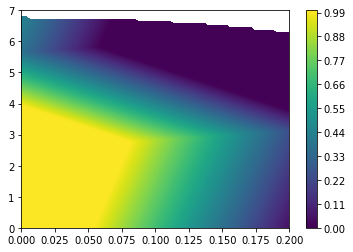

In [8]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_opt, levels=100)
fig.colorbar(cs)
plt.show()

In [9]:
parameter_set = Polytope(np.vstack((np.eye(2), -np.eye(2))), np.concatenate((mpc_controller.x_max, -mpc_controller.x_min)))

In [10]:
sampler = RandomSampler(mpc_controller, parameter_set)
parameter_samples, variable_samples = sampler.sample(5000, seed=0)

100%|██████████| 5000/5000 [00:49<00:00, 101.92it/s]


In [11]:
parameter_samples = torch.from_numpy(parameter_samples).float()
variable_samples  = torch.from_numpy(variable_samples).float()

torch.save(parameter_samples, 'parameter_samples.pt')
torch.save(variable_samples, 'variable_samples.pt')

In [12]:
parameter_samples = torch.load('parameter_samples.pt')
variable_samples  = torch.load('variable_samples.pt')

In [13]:
class DCDCConverterDataset(Dataset):
    def __init__(self, parameter_samples, variable_samples):
        self.parameter_samples = parameter_samples
        self.variable_samples = variable_samples

    def __len__(self):
        return self.parameter_samples.shape[0]

    def __getitem__(self, idx):
        return self.parameter_samples[idx, :], self.variable_samples[idx, :]

In [14]:
dataset = DCDCConverterDataset(parameter_samples, variable_samples)

seed = 1
train_set_ratio = 0.8

train_set_size = int(len(dataset) * train_set_ratio)
test_set_size = len(dataset) - train_set_size
train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))

In [15]:
class QPLayerProblem(QPProblem):
    def __init__(self, H, nz, eps=1e-4):
        self.z = cp.Variable(nz)
        self.x = cp.Parameter(nz)
        self.prob = cp.Problem(cp.Minimize(cp.sum_squares(H @ self.z + self.x) + eps * cp.sum_squares(self.z)), [self.z >= 0])
        
    def problem(self):
        return self.prob

    def parameters(self):
        return [self.x]

    def variables(self):
        return [self.z]
    
    def solve(self, x):
        self.x.value = x
        self.prob.solve(solver=cp.GUROBI)

        solution = {self.z: self.z.value}
        return solution


class QPModule(nn.Module):
    def __init__(self, nz, eps=1e-4):
        super(QPModule, self).__init__()
        self.H = nn.Parameter(torch.randn(nz, nz))
        self.nz = nz
        self.eps = eps
        H = cp.Parameter((nz, nz))
        prob = QPLayerProblem(H, nz, eps)
        self.layer = CvxpyLayer(prob.problem(), [H] + prob.parameters(), prob.variables())

    def forward(self, x):
        return self.layer(self.H, x, solver_args={'solve_method':'ECOS'})[0]
        
    def milp_layer(self, depth):
        prob = QPLayerProblem(self.H.detach().cpu().numpy(), self.nz, self.eps)
        return QPLayer(prob, depth, skip_bound_computation=False)

In [16]:
class SatModule(nn.Module):
    def __init__(self, num_features, x_min, x_max):
        super(SatModule, self).__init__()
        self.num_features = num_features
        self.x_min = x_min
        self.x_max = x_max
        
    def forward(self, x):
        return torch.max(torch.min(x, torch.from_numpy(self.x_max).float()), torch.from_numpy(self.x_min).float())
    
    def milp_layer(self, depth):
        return SeqLayer([
            LinearLayer(np.eye(self.num_features), -self.x_min, depth),
            ReluLayer(self.num_features, depth),
            LinearLayer(np.eye(self.num_features), self.x_min, depth),
            LinearLayer(-np.eye(self.num_features), self.x_max, depth),
            ReluLayer(self.num_features, depth),
            LinearLayer(-np.eye(self.num_features), self.x_max, depth)
        ], depth)

In [17]:
nz = 3

net = nn.Sequential(
    nn.Linear(mpc_controller.parameter_size(), nz),
    QPModule(nz),
    nn.Linear(nz, mpc_controller.variable_size()),
    # SatModule(mpc_controller.variable_size(), mpc_controller.u_min, mpc_controller.u_max)
)

In [18]:
def loss_function(model, data, target):
    output = model(data)
    loss = F.mse_loss(output, target)
    loss += 1e2 / len(data) * F.mse_loss(model(torch.from_numpy(mpc_controller.xs).float().to(data.device)), torch.from_numpy(mpc_controller.us).float().to(data.device))
    return loss

In [19]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        loss = loss_function(model, data, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader)

In [20]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            test_loss += loss_function(model, data, target).item()

    test_loss /= len(test_loader)

    print('Test set: Average loss: {:.6f}\n'.format(test_loss))

In [21]:
use_cuda = torch.cuda.is_available()

device = torch.device('cuda' if use_cuda else 'cpu')

train_kwargs = {'batch_size': 50}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    
train_loader = DataLoader(train_set, **train_kwargs)
test_loader = DataLoader(test_set, **test_kwargs)

In [22]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
for epoch in range(1, 50 + 1):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader, epoch)

Train Epoch: 1 [0/4000 (0%)]	Loss: 0.851654
Train Epoch: 1 [1000/4000 (25%)]	Loss: 0.207859
Train Epoch: 1 [2000/4000 (50%)]	Loss: 0.157280
Train Epoch: 1 [3000/4000 (75%)]	Loss: 0.088759
Test set: Average loss: 0.061632

Train Epoch: 2 [0/4000 (0%)]	Loss: 0.052453
Train Epoch: 2 [1000/4000 (25%)]	Loss: 0.039723
Train Epoch: 2 [2000/4000 (50%)]	Loss: 0.044044
Train Epoch: 2 [3000/4000 (75%)]	Loss: 0.026050
Test set: Average loss: 0.022033

Train Epoch: 3 [0/4000 (0%)]	Loss: 0.017406
Train Epoch: 3 [1000/4000 (25%)]	Loss: 0.012657
Train Epoch: 3 [2000/4000 (50%)]	Loss: 0.012608
Train Epoch: 3 [3000/4000 (75%)]	Loss: 0.013650
Test set: Average loss: 0.007652

Train Epoch: 4 [0/4000 (0%)]	Loss: 0.011822
Train Epoch: 4 [1000/4000 (25%)]	Loss: 0.007598
Train Epoch: 4 [2000/4000 (50%)]	Loss: 0.003343
Train Epoch: 4 [3000/4000 (75%)]	Loss: 0.006246
Test set: Average loss: 0.005198

Train Epoch: 5 [0/4000 (0%)]	Loss: 0.003914
Train Epoch: 5 [1000/4000 (25%)]	Loss: 0.006898
Train Epoch: 5 [2000

In [23]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(1, 10 + 1):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader, epoch)

Train Epoch: 1 [0/4000 (0%)]	Loss: 0.003976
Train Epoch: 1 [1000/4000 (25%)]	Loss: 0.005068
Train Epoch: 1 [2000/4000 (50%)]	Loss: 0.002847
Train Epoch: 1 [3000/4000 (75%)]	Loss: 0.005204
Test set: Average loss: 0.004582

Train Epoch: 2 [0/4000 (0%)]	Loss: 0.003730
Train Epoch: 2 [1000/4000 (25%)]	Loss: 0.005082
Train Epoch: 2 [2000/4000 (50%)]	Loss: 0.002853
Train Epoch: 2 [3000/4000 (75%)]	Loss: 0.005183
Test set: Average loss: 0.004582

Train Epoch: 3 [0/4000 (0%)]	Loss: 0.003689
Train Epoch: 3 [1000/4000 (25%)]	Loss: 0.005063
Train Epoch: 3 [2000/4000 (50%)]	Loss: 0.002861
Train Epoch: 3 [3000/4000 (75%)]	Loss: 0.005187
Test set: Average loss: 0.004583

Train Epoch: 4 [0/4000 (0%)]	Loss: 0.003677
Train Epoch: 4 [1000/4000 (25%)]	Loss: 0.005062
Train Epoch: 4 [2000/4000 (50%)]	Loss: 0.002867
Train Epoch: 4 [3000/4000 (75%)]	Loss: 0.005189
Test set: Average loss: 0.004584

Train Epoch: 5 [0/4000 (0%)]	Loss: 0.003675
Train Epoch: 5 [1000/4000 (25%)]	Loss: 0.005064
Train Epoch: 5 [2000

In [24]:
net_sat = nn.Sequential(
    *net,
    SatModule(mpc_controller.variable_size(), mpc_controller.u_min, mpc_controller.u_max)
)

In [25]:
torch.save({'state_dict': net_sat.state_dict()}, 'dc_dc_converter_qp.pt')

In [26]:
saved_model = torch.load('dc_dc_converter_qp.pt')
net_sat.load_state_dict(saved_model['state_dict'])

<All keys matched successfully>

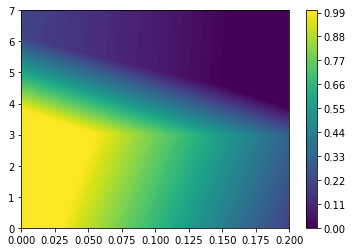

In [27]:
z_net = np.vstack((x.flatten(), y.flatten())).T
z_net = net_sat(torch.from_numpy(z_net).float())
z_net = z_net.detach().cpu().numpy()
z_net = z_net.reshape(x.shape)

fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_net, levels=100)
fig.colorbar(cs)
plt.show()

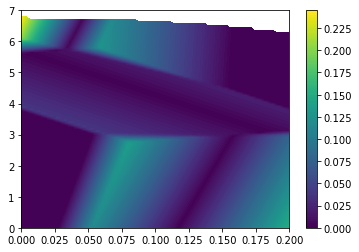

In [28]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
fig.colorbar(cs)
plt.show()

In [29]:
verifier = Verifier(parameter_set, mpc_controller, net_sat)

In [30]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=Bound.ZONO_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

Neural Network Bounds:
lower bound: [0.]
upper bound: [1.]


In [31]:
bound, parameters = verifier.find_max_abs_diff()

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 235 rows, 302 columns and 591 nonzeros
Model fingerprint: 0x10e88d71
Model has 148 general constraints
Variable types: 229 continuous, 73 integer (73 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-02, 7e+00]
  RHS range        [7e-18, 7e+00]
Presolve removed 118 rows and 142 columns
Presolve time: 0.01s
Presolved: 117 rows, 160 columns, 415 nonzeros
Presolved model has 47 SOS constraint(s)
Variable types: 109 continuous, 51 integer (51 binary)

Root relaxation: objective 9.770334e-01, 124 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

In [32]:
print(f'Maximum absolute Error Bound between MPC and NN: {bound} at {parameters}')
u0_mpc = mpc_controller.solve(np.array(parameters))[mpc_controller.u0][0]
u0_net = net_sat(torch.from_numpy(np.array(parameters)).float()).detach().numpy()[0]
print(f'Double Checking by calulcaing error at this position: {u0_mpc - u0_net}')

Maximum absolute Error Bound between MPC and NN: 0.24405720844457435 at [0.0, 6.787028776081566]
Double Checking by calulcaing error at this position: 0.2440572364307761


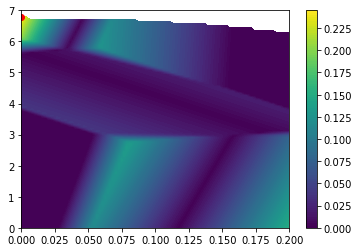

In [33]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
ax.plot(parameters[0], parameters[1], 'ro')
fig.colorbar(cs)
plt.show()

In [34]:
bound, parameters = verifier.verify_stability()

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 355 rows, 361 columns and 805 nonzeros
Model fingerprint: 0x62ddff16
Model has 63 quadratic objective terms
Model has 146 general constraints
Variable types: 288 continuous, 73 integer (73 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 3e+02]
  Bounds range     [5e-02, 7e+00]
  RHS range        [7e-18, 7e+00]
Presolve removed 213 rows and 172 columns
Presolve time: 0.01s
Presolved: 176 rows, 253 columns, 624 nonzeros
Presolved model has 47 SOS constraint(s)
Presolved model has 32 quadratic constraint(s)
Presolved model has 31 bilinea

In [35]:
print(f'Stability bound: {bound} at {parameters}, should be >=0 for stability')

Stability bound: -0.00015372608290168543 at [0.05076446623744696, 4.987464391602321], should be >=0 for stability
